In [46]:
library(tidyverse)
library(grid)
library(gridExtra)

source("../evaluation_utils/plots_eda.R")
source("../evaluation_utils/filtering.R")

## Best studies:
- PRJEB27928 (GERMANY)
- PRJEB6070  (FRANCE)
- PRJNA429097 (CHINA)
- PRJEB10878 (CHINA)

5th - PRJNA731589 (CHINA)

# Load data

In [47]:
metadata <- read.csv('/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/raw/metadata_2250_CRC_cohort_20231114.tsv', sep = '\t') %>%
    filter(is.na(to_exclude)) %>%
    filter(class != "adenoma") %>%
    # keep only data from best studies list
    filter(study_accession %in% c("PRJEB27928", "PRJEB6070", "PRJEB10878", "PRJNA429097", "PRJNA731589"))

cat('Metadata shape:', dim(metadata), '\n')
head(metadata)

Metadata shape: 686 34 


,sample,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,⋯,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,SRS9032198,74585900,60354816,80.91987,60354816,80.91987,283,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,62,19.33,healthy,NA
2,SRS9032197,60777874,50754389,83.50800,50754389,83.50800,142,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,58,22.61,healthy,NA
3,SRS9032196,65367586,53951871,82.53612,53951871,82.53612,291,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,63,30.48,healthy,NA
4,SRS9032195,66924702,53388902,79.77458,53388902,79.77458,461,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,56,27.93,healthy,NA
5,SRS9032194,54591836,45123665,82.65643,45123665,82.65643,299,NA,NA,NA,⋯,gut,stool,H,NA,NA,male,59,20.72,healthy,NA
6,SRS9032193,56774092,44995087,79.25285,44995087,79.25285,398,NA,NA,NA,⋯,gut,stool,H,NA,NA,female,63,20.29,healthy,NA


In [48]:
funct_counts <- read.csv("/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/raw/functional_signal_raw_count_2250_CRC_cohort_20240221.tsv", sep = "\t")
funct_counts <- funct_counts %>% column_to_rownames('modules_id')
funct_counts <- funct_counts[, colnames(funct_counts) %in% metadata$sample]
funct_counts <- funct_counts[, metadata$sample]

dim(funct_counts)
head(funct_counts)


[1] 378 686

,SRS9032198,SRS9032197,SRS9032196,SRS9032195,SRS9032194,SRS9032193,SRS9032192,SRS9032191,SRS9032190,SRS9032189,⋯,ERS848631,ERS848630,ERS848629,ERS848628,ERS848626,ERS848622,ERS848621,ERS848620,ERS848619,ERS848618
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
M00001,467312,681944,356819,596958,703180,553546,449301,543069,378029,520249,⋯,532721,663852,481401,497312,582840,413620,639295,583849,459364,545955
M00002,428908,669050,307744,496500,373964,361191,448629,522626,245082,461544,⋯,513487,567039,364108,486857,554494,554816,591804,472040,433227,468454
M00003,309085,529968,253452,376474,201643,199772,447701,339990,132320,372456,⋯,414129,334409,295643,387763,486288,143754,368025,238676,299189,225274
M00004,260956,33623,132119,252125,17532,52425,442048,211270,55717,400649,⋯,145339,201187,64727,338079,401972,90824,79929,170558,108122,97647
M00005,670541,718567,605769,637821,743839,645320,449841,571395,543771,537809,⋯,569068,659122,655757,532813,610976,593058,744184,822637,626567,660771
M00006,283408,35781,136729,267888,21269,61948,442078,300116,66770,438214,⋯,162058,248084,77948,338403,412354,101480,100887,176832,138581,109958


# Preprocessing

## Filtering

In [49]:
# filter out rows with 0 counts
cat('Before filtering, shape:', dim(funct_counts), '\n')
funct_counts <- funct_counts[rowSums(funct_counts) > 0, ]
cat('After filtering, shape:', dim(funct_counts), '\n')

Before filtering, shape: 378 686 
After filtering, shape: 375 686 


In [50]:
sum(funct_counts == 0) / (nrow(funct_counts) * ncol(funct_counts))

[1] 0.272381

In [51]:
# convert zeros to NA
funct_counts[funct_counts == 0] <- NA

# keep only rows that have at least 2 non-NA values per study
funct_counts <- filter_per_center(funct_counts, metadata, 'sample', unique(metadata$study_accession), 'study_accession')

Filtering by center - two not-NA per center
	Before filtering: 375 686 
	After filtering: 324 686 


In [52]:
sum(is.na(funct_counts)) / (nrow(funct_counts) * ncol(funct_counts))

[1] 0.1606693

## log transform

In [61]:
funct_counts[is.na(funct_counts)] <- 0
logmin_func_counts <- log2(funct_counts + min(funct_counts[funct_counts > 0], na.rm = TRUE)/2)
dim(logmin_func_counts)

[1] 324 686

## plots

In [62]:
logmin_func_counts <- logmin_func_counts %>% as.data.frame()
metadata <- metadata %>% as.data.frame()

In [63]:
pca_plot_study <- pca_plot(
    logmin_func_counts, metadata, 
    title = "PCA plot of Functional Signal, log2(counts + 0.5min)",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")

pca_plot_class <- pca_plot(
    logmin_func_counts, metadata, 
    title = "PCA plot of Functional Signal, log2(counts + 0.5min)",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_func_counts, metadata, 
    title = "UMAP plot of Functional Signal, log2(counts + 0.5min)", color_column = "study_accession")
umap_plot_class <- umap_plot(
    logmin_func_counts, metadata, 
    title = "UMAP plot of Functional Signal, log2(counts + 0.5min)", color_column = "class")

# # replace 0 with NA
# funct_counts[funct_counts == 0] <- NA
# logmin_func_counts <- log2(funct_counts)

boxplot_results <- boxplot_plot(
    logmin_func_counts, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of Functional Signal, log2(counts) with NA")

density_plot <- plotIntensityDensity(
    logmin_func_counts, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'study_accession',
    title = "Density plot of Functional Signal, log2(counts) with NA")



No id variables; using all as measure variables



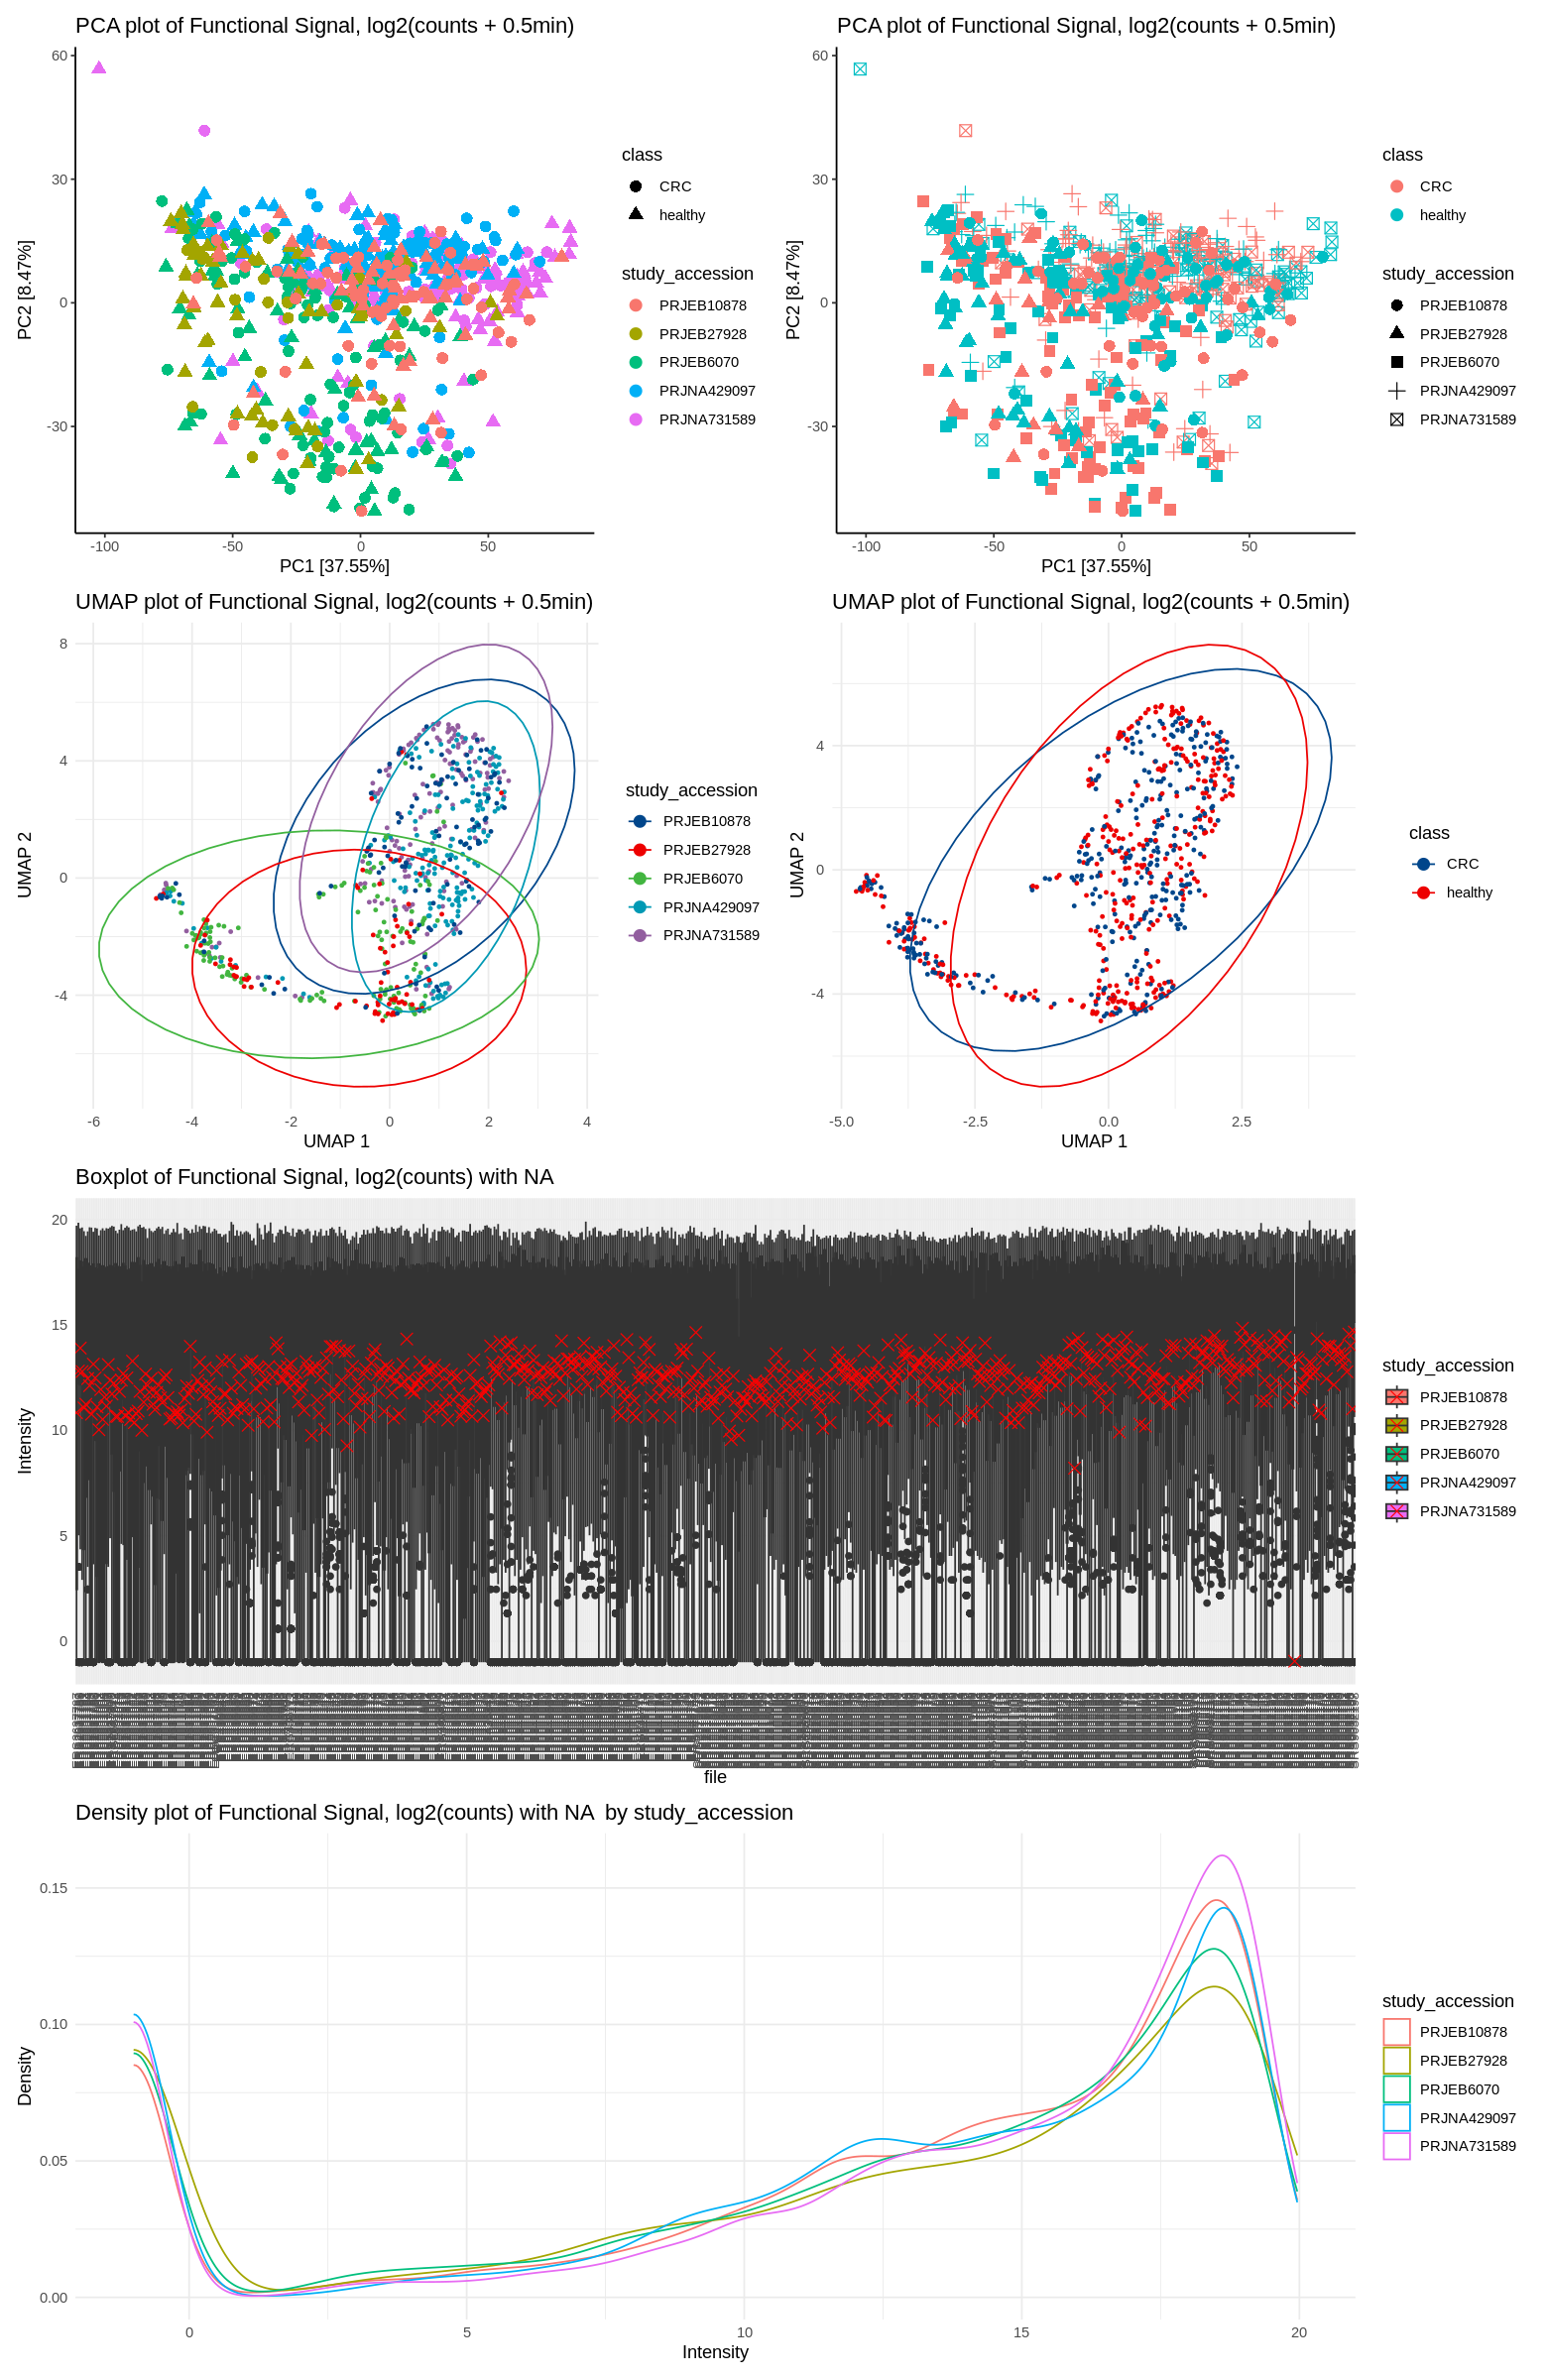

In [64]:
layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=20)
layout

## QU norm

In [57]:
cat('Before normalization, shape:', dim(funct_counts), '\n')

quantileExpressed <- apply(funct_counts, 2, function(x) { quantile(x[x > 0], 0.75, na.rm = TRUE) })
funct_counts_norm <- t(t(funct_counts) / quantileExpressed)

# replace NA with 0
funct_counts_norm[is.na(funct_counts_norm)] <- 0

cat('After normalization, shape:', dim(funct_counts_norm), '\n')
cat('% of zeros:', sum(funct_counts_norm == 0) / (nrow(funct_counts_norm) * ncol(funct_counts_norm)), '\n')


Before normalization, shape: 324 686 
After normalization, shape: 324 686 
% of zeros: 0.1606693 


No id variables; using all as measure variables

Warning message:
“Removed 35711 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 35711 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 35711 rows containing non-finite values (`stat_density()`).”


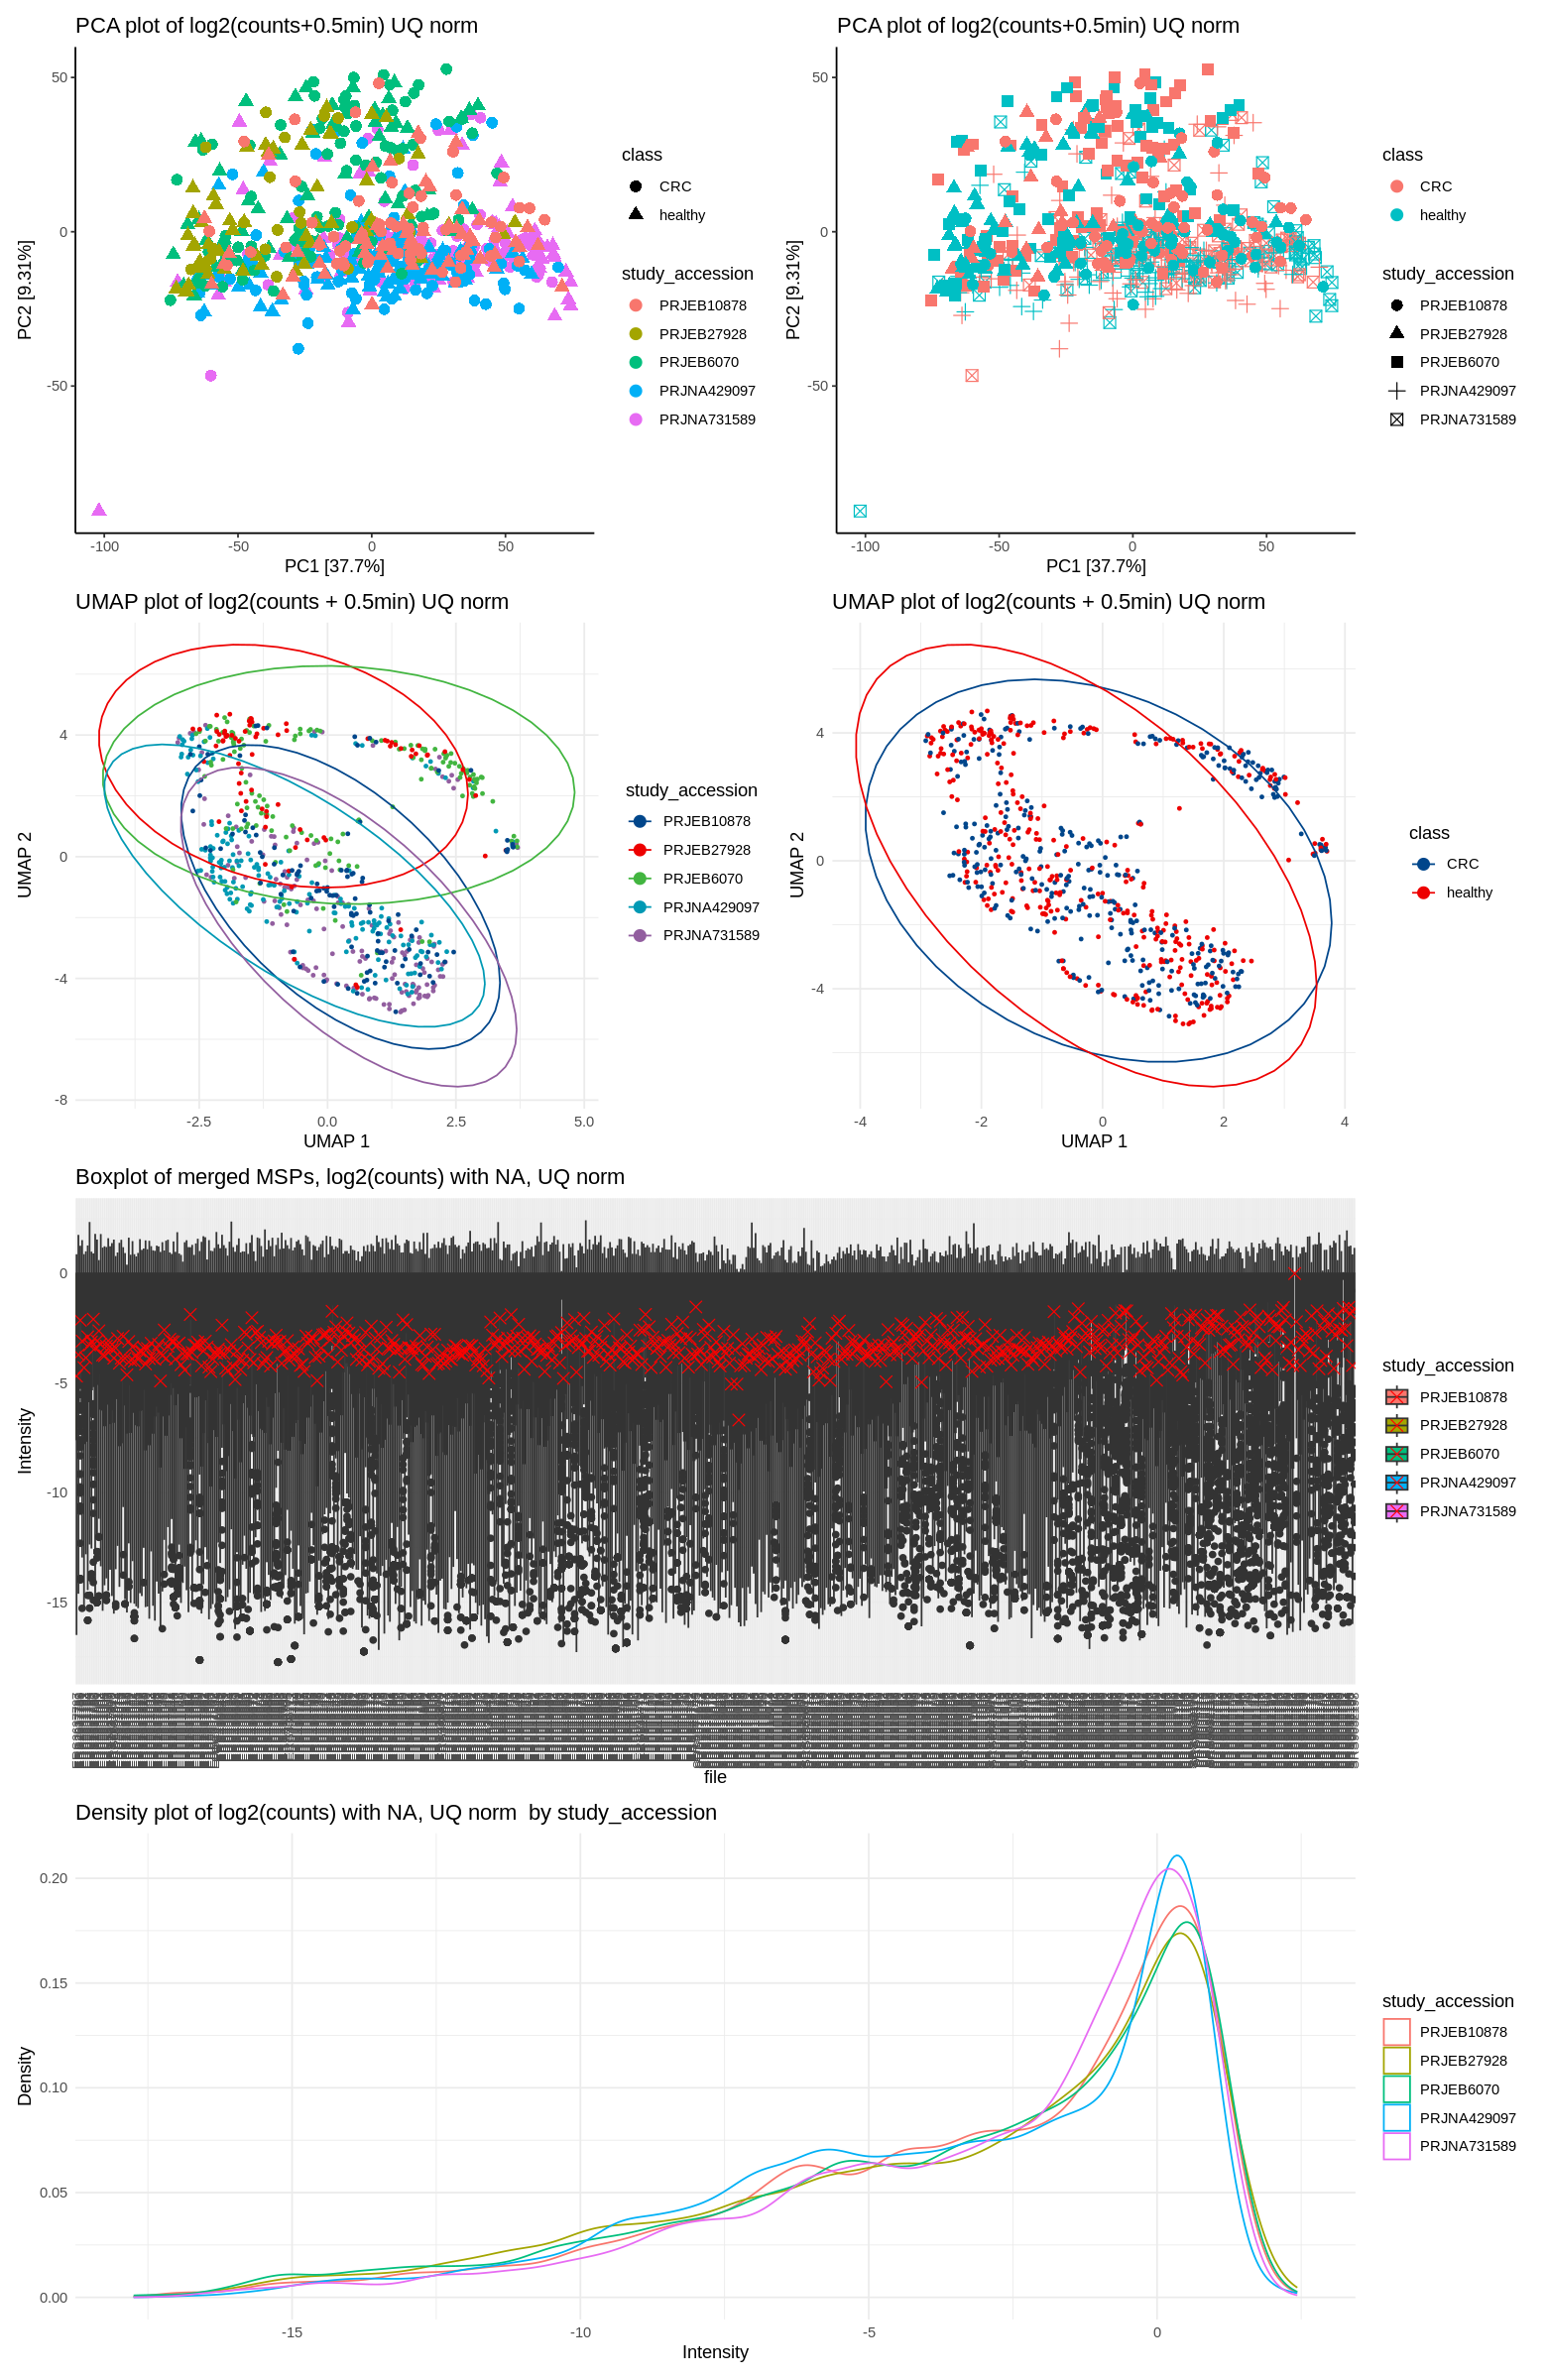

In [52]:
funct_counts_norm[is.na(funct_counts_norm)] <- 0
funct_counts_norm <- funct_counts_norm %>% as.data.frame()
logmin_msp_counts_norm <- log2(funct_counts_norm + min(funct_counts_norm[funct_counts_norm > 0])/2)

pca_plot_study <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")

pca_plot_class <- pca_plot(
    logmin_msp_counts_norm, metadata, 
    title = "PCA plot of log2(counts+0.5min) UQ norm",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(counts + 0.5min) UQ norm", color_column = "study_accession")
umap_plot_class <- umap_plot(
    logmin_msp_counts_norm, metadata, 
    title = "UMAP plot of log2(counts + 0.5min) UQ norm", color_column = "class")

# replace 0 with NA
funct_counts_norm[funct_counts_norm == 0] <- NA
logmin_msp_counts_norm <- log2(funct_counts_norm)

boxplot_results <- boxplot_plot(
    logmin_msp_counts_norm, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of merged MSPs, log2(counts) with NA, UQ norm")

density_plot <- plotIntensityDensity(
    logmin_msp_counts_norm, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'study_accession',
    title = "Density plot of log2(counts) with NA, UQ norm")


layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=20)
layout


In [53]:
# save normalized data with 0s
funct_counts_norm[is.na(funct_counts_norm)] <- 0
write.table(funct_counts_norm %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/normalized_funct_5centers.tsv", sep = "\t", quote = FALSE)

#save unnormalized data with NAs
funct_counts[is.na(funct_counts)] <- 0
write.table(funct_counts %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/raw_funct_5centers.tsv", sep = "\t", quote = FALSE)

# # save metadata
# write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/before/metadata_5centers.tsv", sep = "\t", quote = FALSE)

# Batch effects correction

In [54]:
# zeros to NA
funct_counts_norm[is.na(funct_counts_norm)] <- 0

# arrane normalized data 
funct_counts_norm <- funct_counts_norm %>% as.data.frame()
funct_counts_norm <- funct_counts_norm[,metadata$sample]

In [55]:
# create design
design = model.matrix(~class, data = metadata)

# log2
logmin_msp_counts_norm <- log2(funct_counts_norm+ min(funct_counts_norm[funct_counts_norm > 0])/2)

msp_norm_corrected <- limma::removeBatchEffect(logmin_msp_counts_norm, metadata$study_accession, design = design) %>% as.data.frame()


No id variables; using all as measure variables



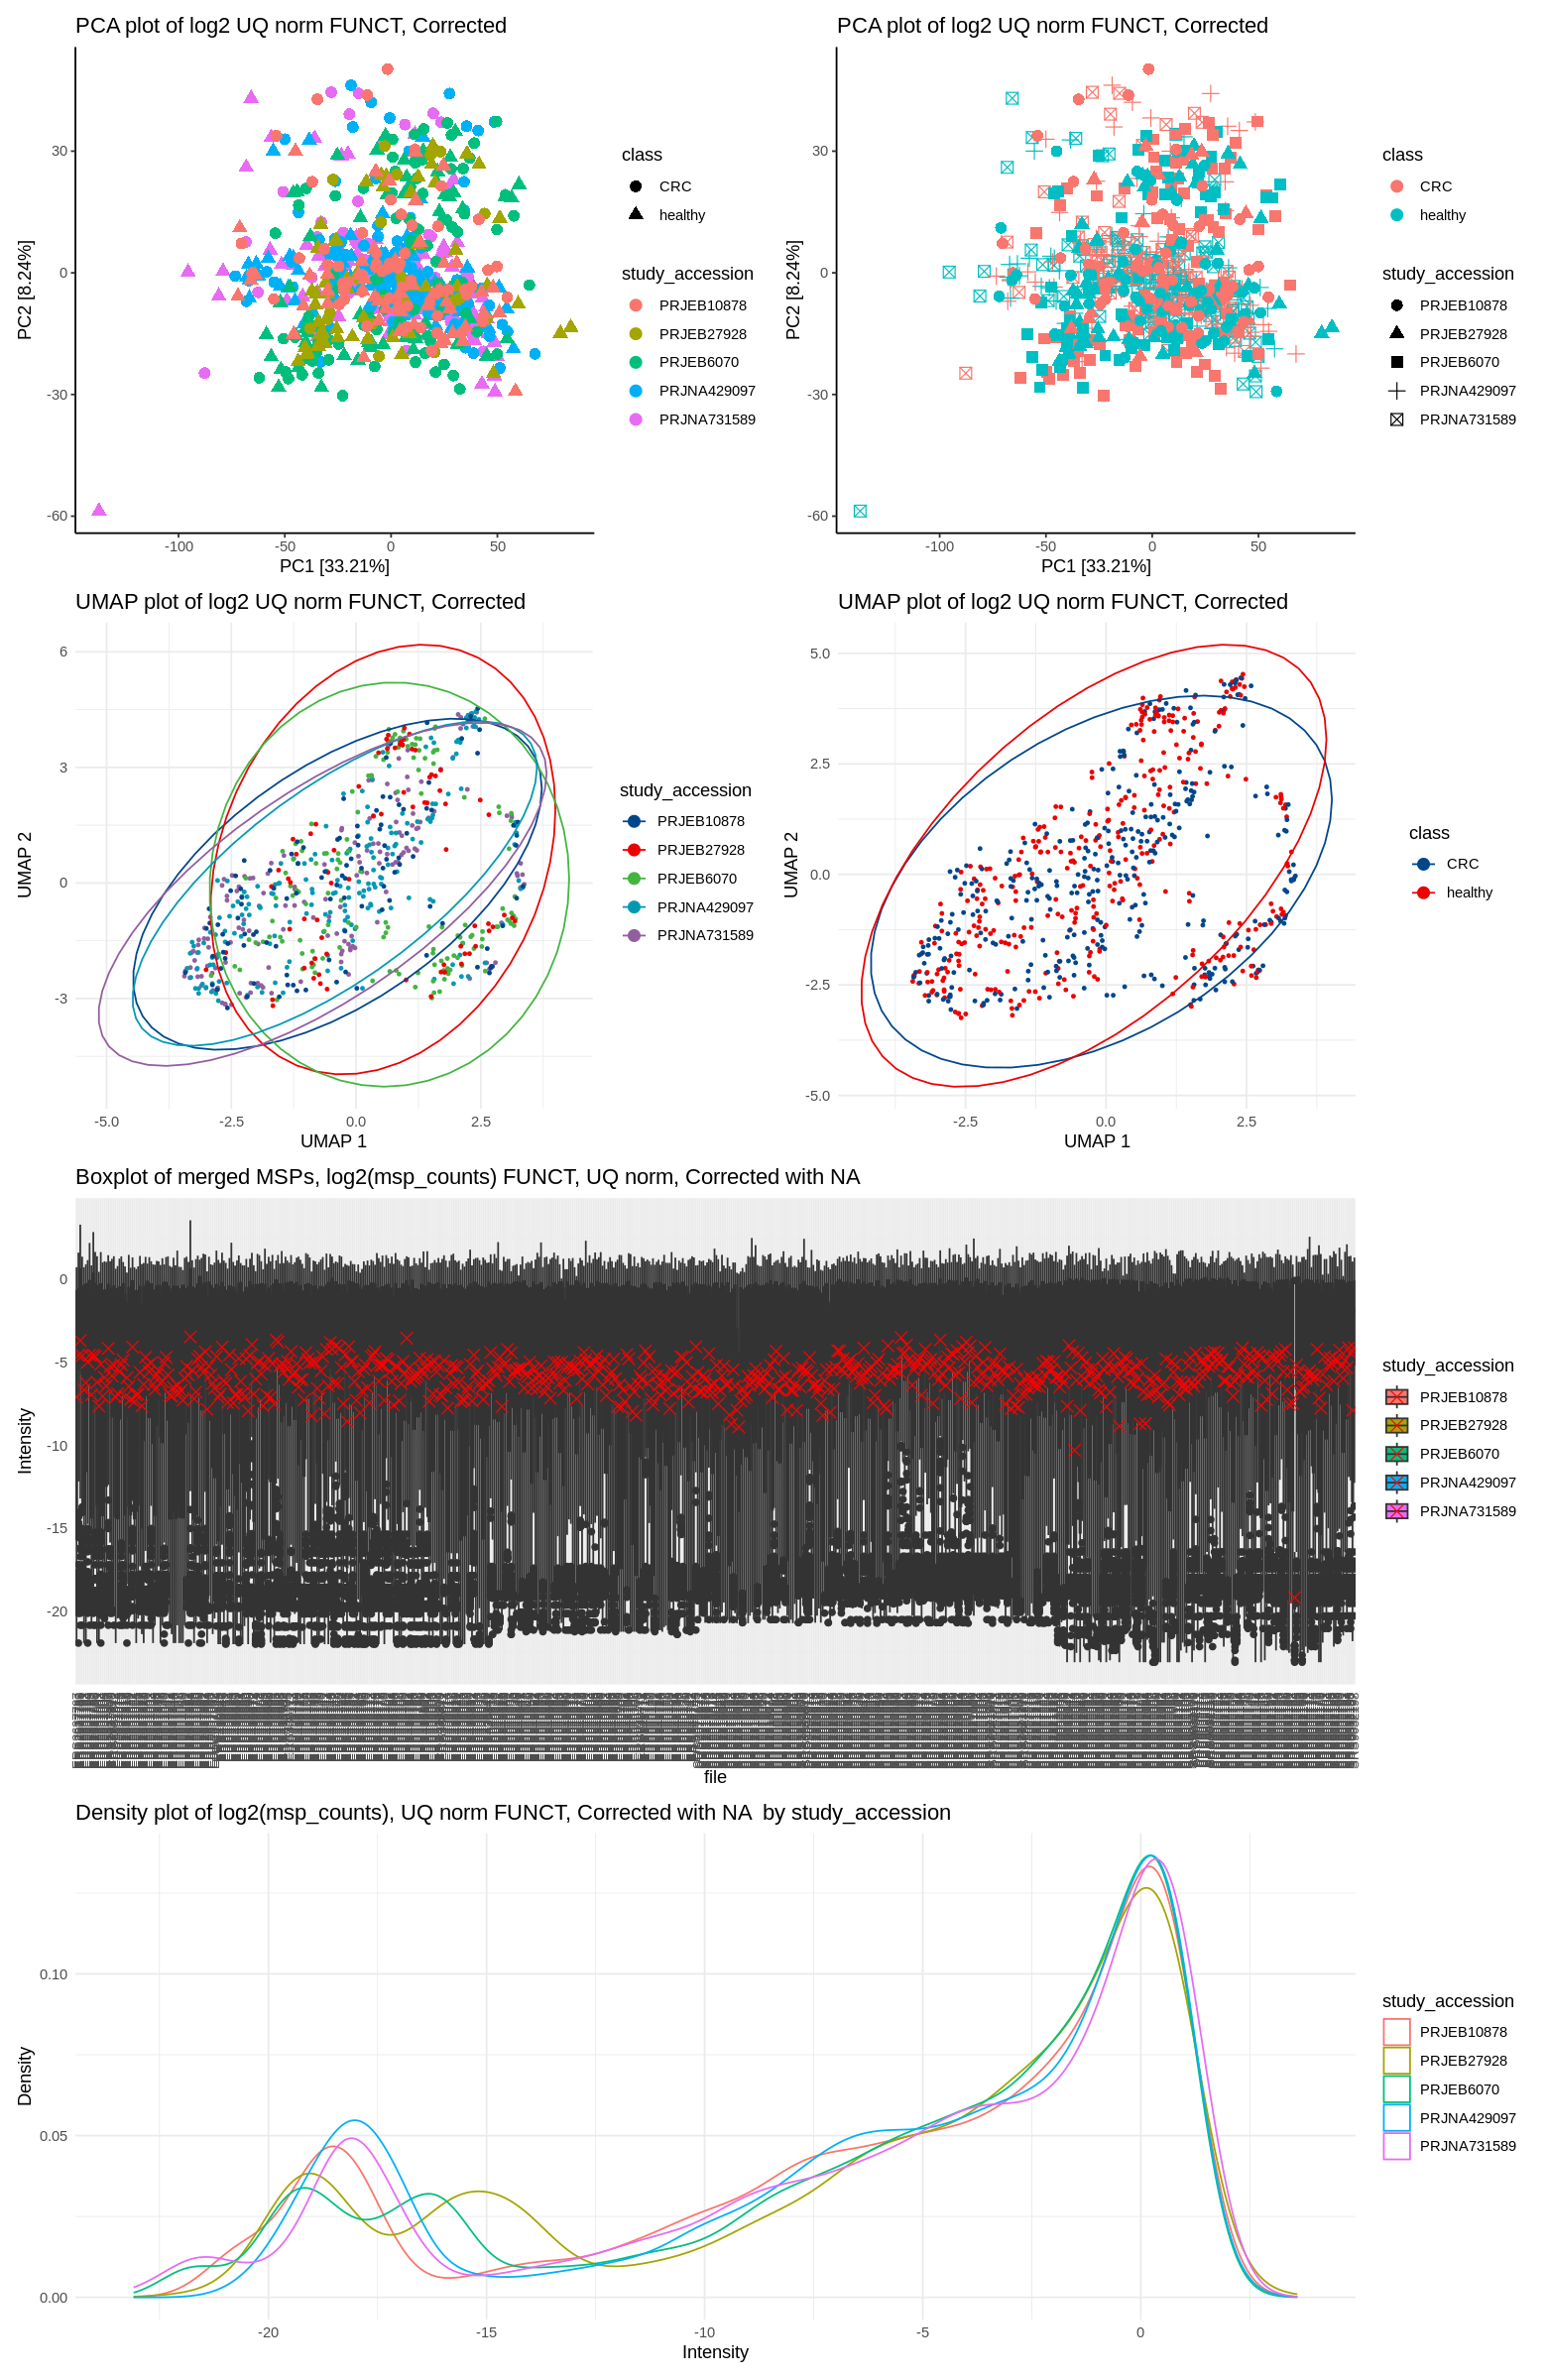

In [56]:
pca_plot_study <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm FUNCT, Corrected",
    quantitative_col_name = 'sample',
    col_col = "study_accession", shape_col = "class")

pca_plot_class <- pca_plot(
    msp_norm_corrected, metadata, 
    title = "PCA plot of log2 UQ norm FUNCT, Corrected",
    quantitative_col_name = 'sample',
    shape_col = "study_accession", col_col = "class")

umap_plot_study <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm FUNCT, Corrected", color_column = "study_accession")
umap_plot_class <- umap_plot(
    msp_norm_corrected, metadata, 
    title = "UMAP plot of log2 UQ norm FUNCT, Corrected", color_column = "class")

# replace 0 with NA
# msp_norm_corrected[msp_norm_corrected == 0] <- NA

boxplot_results <- boxplot_plot(
    msp_norm_corrected, metadata,
    quantitativeColumnName = 'sample', color_col = "study_accession",
    title = "Boxplot of merged MSPs, log2(msp_counts) FUNCT, UQ norm, Corrected with NA")

density_plot <- plotIntensityDensity(
    msp_norm_corrected, metadata, 
    quantitativeColumnName = 'sample', colorColumnName = 'study_accession',
    title = "Density plot of log2(msp_counts), UQ norm FUNCT, Corrected with NA")


layout <- (pca_plot_study | pca_plot_class) /
          (umap_plot_study | umap_plot_class) /
          boxplot_results /
          density_plot

options(repr.plot.width=13, repr.plot.height=20)
layout


In [57]:
# save results to files
write.table(funct_counts_norm %>% rownames_to_column('MSP'), 
    file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/after/normalized_funct_5centers_corrected.tsv", sep = "\t", quote = FALSE)

# write.table(metadata, file = "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/after/metadata_5centers_corrected.tsv", sep = "\t", quote = FALSE)